<h1 style="font-size: 42px; text-align: center;">HW5: Monte Carlo Tree Search and Naive Search</h1>

> **Full Name:** `Amir Kooshan Fattah Hesari`  
> **Student ID:** `401102191`  

<p align="center">
    <a href="https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW5_MCTS.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
    </a>
    <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/RL_HW5_MCTS.ipynb">
        <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle">
    </a>
</p>

---

## 📌 Overview

Welcome to **HW5**, where you will explore and implement search algorithms in reinforcement learning!  
In this assignment, you will:

✅ Implement **Monte Carlo Tree Search (MCTS)** and a **Naive Search Algorithm**.  
✅ Develop an agent that utilizes these techniques for decision-making.  
✅ Test and evaluate the performance of your agent.  

### 📂 Notebook Structure:
1️⃣ **Environment Definition**  
2️⃣ **Search Algorithms: Naive Search & MCTS**  
3️⃣ **Agent Implementation**  
4️⃣ **Training & Testing Loop**  

💡 *Each section includes explanations, docstrings, and `TODO` placeholders for missing implementations. Fill in the gaps and complete the assignment!*  

🚀 *Let's get started!*  


# Detailed Explanation of the Overall Algorithm

This notebook implements a MuZero-like approach to reinforcement learning, as described in the paper  
[“Mastering Atari, Go, Chess and Shogi by Planning with a Learned Model” (Schrittwieser et al., 2019)](https://arxiv.org/abs/1911.08265).  
Below is an overview of the key components and how they work together:

---

## 1. Representation, Dynamics, and Prediction Networks

MuZero (and algorithms inspired by it) relies on three core neural networks:

1. **Representation Network (`RepresentationNet`)**  
   - **Goal**: Convert raw observations (e.g., game frames, board states) into a latent (hidden) state.  
   - **Why It Matters**: By encoding high-dimensional inputs (like pixel images) into a more compact form, downstream modules can operate efficiently on this latent space rather than the raw data.

2. **Dynamics Network (`DynamicsNet`)**  
   - **Goal**: Given the current hidden state and an action, predict the **next hidden state** and an **immediate reward estimate**.  
   - **Why It Matters**: This is the “model” portion of MuZero. It simulates how the hidden state changes when an action is taken, letting the algorithm plan forward without needing a hand-crafted or perfect simulator.

3. **Prediction Network (`PredictionNet`)**  
   - **Goal**: From a hidden state, predict:
     1. **A policy distribution** (probabilities of selecting each possible action)
     2. **A value estimate** (scalar measure of how good or bad the state is)  
   - **Why It Matters**: This guides the search and learning, telling us which actions are promising (policy) and how favorable the current position might be (value).

---

## 2. Monte Carlo Tree Search (MCTS) and Naive Depth Search

1. **Monte Carlo Tree Search (`MCTS` Class)**  
   - **Core Idea**: Repeatedly simulate many “what if?” scenarios (rollouts) to gather statistics on which actions lead to higher value.  
   - **Key Methods**:  
     - `run(...)`: Manages the entire search process from the root hidden state.  
     - `_expand_node(...)`: Expands a leaf node by calling the dynamics and prediction networks.  
     - `_backpropagate(...)`: Propagates the newly obtained value estimates back up the search path.  
     - `_calc_ucb(...)`: Calculates an Upper Confidence Bound (UCB) score to balance exploration (trying new actions) and exploitation (using known good actions).  
     - `_compute_pi()`: Aggregates the visit counts of each child action at the root to form a final policy distribution.  

2. **Naive Depth Search (`naive_depth_search(...)`)**  
   - **Core Idea**: Look ahead a fixed depth in a brute-force manner, expanding all action sequences up to that depth.  
   - **Why It Matters**: Though less sophisticated than MCTS, it offers a simpler example of planning. It enumerates action branches, accumulates rewards and discounted values, and then picks the best sequence.

---

## 3. Buffer Replay

- **Purpose**: Store entire trajectories (episodes) of experience, then allow sampling of smaller segments (sub-trajectories) for training.  
- **How**:  
  1. **`add_trajectories(...)`**: Inserts full episodes into the buffer.  
  2. **`sample_sub_trajectory(...)`**: Retrieves a sub-trajectory of length `k` (for an n-step return) from the stored episodes.  
  3. **`sample_batch(...)`**: Returns a batch of sub-trajectories for training the neural networks.  

---

## 4. Agent

- **Role**: Central coordinator that uses the networks (Representation, Dynamics, Prediction) and search algorithms (MCTS or naive) to choose actions.  
- **Key Functions**:
  1. **`inference(...)`**: Given an observation, the agent converts it to a hidden state, then either:
     - Runs MCTS to derive a policy (if `search_type="mcts"`)
     - Performs a naive depth search (if `search_type="naive"`)
     - Or uses the direct policy from the `PredictionNet` (if no search is enabled)  
    The chosen action, along with the policy distribution and value estimate, is returned.
  2. **`initial_step(...)`**: Processes the initial raw observation into a hidden state and then obtains policy/value estimates.  
  3. **`rollout_step(...)`**: Given a hidden state plus actions, calls the `DynamicsNet` to get the next hidden state and reward, and the `PredictionNet` to predict policy/value at that new state.

---

## 5. Overall Training Procedure

1. **Collect Trajectories**:  
   - The agent interacts with the environment, using either MCTS or naive search to pick actions.  
   - The environment returns observations/rewards that form trajectories (episodes).

2. **Store in Replay**:  
   - These full trajectories are added to the `BufferReplay`.

3. **Sample Mini-Batches**:  
   - The training script samples sub-trajectories from the buffer (via `sample_sub_trajectory(...)` or `sample_batch(...)`).

4. **Unroll the Model**:  
   - For each sampled sub-trajectory, the code unrolls the networks (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) for multiple steps (up to `k`) to compare the model’s predictions to the actual transitions.

5. **Compute Loss & Update**:  
   - The total loss typically includes terms for:
     - **Value error** (predicted vs. actual return)
     - **Policy error** (predicted policy vs. search-derived/improved policy)
     - **Reward error** (predicted vs. actual immediate reward)  
   - Backpropagation updates the parameters of all three networks end-to-end.

6. **Repeat**:  
   - Continue this cycle of data collection and network updates until convergence.

## Library Imports

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import warnings
warnings.filterwarnings("ignore" , category = DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float
device

device(type='cpu')

In [4]:
##############################################
# Environment Runner
##############################################
class EnvironmentRunner:
    """
    Manages interactions with an OpenAI Gym environment:
    - Resets the environment
    - Steps through it given an agent's actions
    - Logs returns and gathers trajectory data
    """

    def __init__(self, gym_env):
        self.gym_env = gym_env
        self.num_actions = self.gym_env.action_space.n

        self.observation = self.gym_env.reset()
        self.episodes_count = 0


    def run(self, agent, show_render=False):
            """
            Runs one full episode:
            1) Resets environment
            2) Steps until done
            3) Logs returns
            4) Returns the collected trajectory
            """
            obs_list = []
            actions_list = []
            rewards_list = []
            done_list = []
            policy_list = []
            values_list = []

            # initial reset
            self.observation = self.gym_env.reset()
            obs_list.append(torch.tensor(self.observation))

            finished = False
            while not finished:
                # Let agent infer the next action
                chosen_action, distribution, val_est = agent.inference(
                    torch.tensor(self.observation, dtype=dtype, device=device)
                )

                next_obs, reward, finished, info = self.gym_env.step(chosen_action)

                # Store
                obs_list.append(torch.tensor(next_obs))
                actions_list.append(chosen_action)
                policy_list.append(torch.tensor(distribution))
                values_list.append(val_est)
                rewards_list.append(torch.tensor(reward))
                done_list.append(finished)

                # Optional render
                if show_render:
                    self.gym_env.render()
                    time.sleep(0.024)

                self.observation = next_obs

            self.episodes_count += 1
            return self.build_trajectory(obs_list, actions_list, rewards_list, done_list, policy_list, values_list)

    @staticmethod
    def build_trajectory(obs, acts, rews, finished_flags, pols, vals):
        return {
            "obs": obs,
            "actions": acts,
            "rewards": rews,
            "dones": finished_flags,
            "pis": pols,
            "vs": vals,
            "length": len(obs)
        }
        
class LoggingEnvRunner(EnvironmentRunner):
    """
    Extends EnvironmentRunner to log episode returns.
    """
    def __init__(self, env):
        super().__init__(env)
        self.episode_returns = []

    def run(self, agent):
        trajectory = super().run(agent)  # normal run
        # Summation of the episode's rewards:
        ep_return = float(np.sum(trajectory["rewards"]))
        self.episode_returns.append(ep_return)
        return trajectory

In [5]:
class GymWrapper(gym.Wrapper):
    def __init__(self, env, history_len):
        super().__init__(env)
        self.history_len = history_len
        self.obs_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
    def reset(self):
        self.episode_return = 0
        self.observations_rollout = []
        obs = self.env.reset()
        self.observations_rollout.append(obs)
        return self.aggregate()
    def aggregate(self):
        stacked = np.zeros((self.history_len, self.obs_dim))
        current_length = len(self.observations_rollout)
        if current_length == self.history_len:
            stacked = np.array(self.observations_rollout)
        else:
            stacked[self.history_len - current_length :] = np.array(
                self.observations_rollout
            )
        return stacked.flatten().reshape(1, -1)
    def step(self, action):
        next_obs, reward, done, info = self.env.step(action)
        self.update_history(next_obs)
        aggregated_obs = self.aggregate()
        self.episode_return += reward
        if done:
            info["return"] = self.episode_return
        return aggregated_obs, reward, done, info
    def update_history(self, new_obs):
        if len(self.observations_rollout) == self.history_len:
            # drop oldest
            self.observations_rollout = self.observations_rollout[1:]
        self.observations_rollout.append(new_obs)

# `BufferReplay` Class

This class manages a replay buffer for reinforcement learning, specifically storing entire trajectories (episodes). It supports two main operations:

1. **Storing Trajectories**:  
   - `add_trajectories(new_trajectories)`: Appends new trajectories to the buffer. If the capacity is exceeded, it overwrites old trajectories in a circular manner.

2. **Sampling Sub-Trajectories**:  
   - `sample_sub_trajectory(k, n, discount)`: Randomly selects a single trajectory from the buffer, chooses a random start index within that trajectory, and extracts a sub-trajectory of length `k` for training. It also computes an `n`-step return for each step in the sub-trajectory, taking into account the discount factor.  
   - `sample_batch(batch_size, k, n, discount)`: Repeats the above sub-trajectory sampling multiple times to form a training batch.

## Data Structure Returned by `sample_sub_trajectory`

`sample_sub_trajectory` returns a dictionary with the following keys:

- **"obs"**: The observation at the starting point of the sub-trajectory.  
  - Type/Shape: Typically a tensor (or array) representing the state.  
- **"pi"**: A list of policy distributions (one per timestep in the sub-trajectory).  
  - Type/Shape: Each entry is usually a tensor of shape `(num_actions,)`, giving the probability distribution over actions.  
- **"v"**: (If included in your design) a list of value estimates for each step in the sub-trajectory.  
  - Type/Shape: Each entry could be a tensor of shape `(1,)` or just a single scalar representing the value.  
- **"actions"**: A list of integers (or tensors) indicating which action was taken at each step.  
  - Type/Shape: Each entry typically an integer in the range `[0, num_actions-1]`.  
- **"rewards"**: A list of rewards obtained for each step in the sub-trajectory.  
  - Type/Shape: Each entry is typically a scalar tensor (or float).  
- **"return"**: A list of n-step returns corresponding to each timestep in the sub-trajectory.  
  - Type/Shape: Each entry is usually a scalar tensor (or float) representing the discounted sum of rewards plus a discounted bootstrap value.

Overall, this dictionary encapsulates all the necessary data (observation, actions, rewards, policy, value, returns) for training, allowing algorithms to perform n-step updates or other forms of training that depend on short sequences of experience.


In [6]:
class BufferReplay:
    def __init__(self, capacity, num_actions):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.num_actions = num_actions
    def add_trajectories(self, new_trajectories):
        for trajectory in new_trajectories:
            if len(self.memory) < self.capacity:
                self.memory.append(trajectory)
            else:
                self.memory[self.position] = trajectory
            self.position = (self.position + 1) % self.capacity
    def sample_sub_trajectory(self, k, n, discount):
        data = {
            "obs": None,
            "pi": [],
            "v": [],
            "actions": [],
            "rewards": [],
            "return": [],
        }
        # Choose a random trajectory
        mem_idx = np.random.choice(len(self.memory), 1)[0]
        chosen_length = self.memory[mem_idx]["length"]
        last_idx = chosen_length - 1
        # Random start
        start = np.random.choice(chosen_length, 1)[0]
        # We'll record the initial observation
        data["obs"] = self.memory[mem_idx]["obs"][start]
        # Collect data for each unroll step
        for step in range(start, start + k + 1):
            lookahead = step + n
            # If looking beyond trajectory end, v_n = 0
            if lookahead >= last_idx:
                future_value = torch.tensor([0.0], device=device, dtype=dtype)
            else:
                future_value = torch.tensor(self.memory[mem_idx]["vs"][lookahead] * (discount**n),device=device, dtype=dtype)
            # sum of discounted rewards up to n or end
            total_val = future_value.clone()
            max_reward_idx = min(last_idx, lookahead)
            enumer_rewards = list(
                enumerate(self.memory[mem_idx]["rewards"][step:max_reward_idx])
            )
            for i, single_r in enumer_rewards:
                total_val += single_r * (discount**i)
            data["return"].append(total_val)
            # Not storing reward for the very initial step in the unroll
            if step != start:
                if 0 < step <= last_idx:
                    data["rewards"].append(self.memory[mem_idx]["rewards"][step - 1])
                else:
                    data["rewards"].append(torch.tensor([0.0], device=device))
            # Pi distribution
            if 0 <= step < last_idx:
                data["pi"].append(self.memory[mem_idx]["pis"][step])
            else:
                # In case we are beyond the real trajectory
                uniform_probs = np.ones(self.num_actions) / self.num_actions
                data["pi"].append(torch.tensor(uniform_probs, dtype=dtype))
        # Build the real set of actions from the actual trajectory
        max_valid_step = min(last_idx - 1, start + k - 1)
        num_steps_valid = max_valid_step - start
        data["actions"] = self.memory[mem_idx]["actions"][
            start : start + num_steps_valid + 1
        ]
        # Fill with random actions if we unroll beyond the stored trajectory
        fill_count = k - num_steps_valid + 1
        for _ in range(fill_count):
            rand_act = np.random.choice(self.num_actions, 1)[0]
            data["actions"].append(rand_act)
        return data
    def sample_batch(self, batch_size, k, n, discount=0.99):
        batch_data = []
        for _ in range(batch_size):
            sample = self.sample_sub_trajectory(k, n, discount)
            batch_data.append(sample)
        return batch_data
    def __len__(self):
        return len(self.memory)

# Representation, Dynamics, and Prediction Models

These three neural network classes (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) work together to model different aspects of an environment in a reinforcement learning (RL) setting, often inspired by algorithms like MuZero or similar approaches.

1. **`RepresentationNet`**  
   - **Goal**: Transform a raw observation (from the environment) into a **hidden state** vector.  
   - **Role in RL**: This hidden state often serves as a compact, learned representation of the environment’s information and is used by subsequent models (such as `DynamicsNet` and `PredictionNet`) to make predictions about future states, rewards, policies, and values.

2. **`DynamicsNet`**  
   - **Goal**: Predict the **next hidden state** and **immediate reward** from the **current hidden state** and an encoded action.  
   - **Role in RL**: This allows a learning algorithm to “imagine” how the environment transitions forward without directly querying the real environment, enabling planning and lookahead.

3. **`PredictionNet`**  
   - **Goal**: Given a hidden state, output a **policy** (probability distribution over possible actions) and a **value estimate** (scalar).  
   - **Role in RL**:  
     - The **policy** guides action selection, telling us which actions might be best at each timestep.  
     - The **value estimate** helps evaluate how good or bad a particular state is, assisting with learning.

## Form of the Desired Outputs
- **`RepresentationNet`**:  
  Outputs a **hidden state** tensor of shape `(batch_size, hidden_dim)`.
- **`DynamicsNet`**:  
  Outputs two tensors:  
  1. **Next hidden state** of shape `(batch_size, hidden_dim)`  
  2. **Reward estimate** of shape `(batch_size,)`
- **`PredictionNet`**:  
  Outputs two tensors:  
  1. **Policy** of shape `(batch_size, num_actions)`, representing a probability distribution over actions.  
  2. **Value** of shape `(batch_size,)`, representing a scalar estimate of the state value.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RepresentationNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.1):
        super(RepresentationNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # You can adjust the activation here; using ReLU for consistency
        hidden_state = F.relu(x)
        return hidden_state

class DynamicsNet(nn.Module):
    def __init__(self, hidden_dim, action_space, dropout_rate=0.1):
        super(DynamicsNet, self).__init__()
        self.fc1 = nn.Linear(hidden_dim + action_space, 128)
        self.fc2 = nn.Linear(128, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.reward_head = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # Concatenate hidden state and action before passing through the network
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        next_hidden = self.fc2(x)
        next_hidden = F.relu(next_hidden)
        reward = self.reward_head(next_hidden).squeeze(-1)
        return next_hidden, reward

class PredictionNet(nn.Module):
    def __init__(self, hidden_dim, num_actions, dropout_rate=0.1):
        super(PredictionNet, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, num_actions)
        self.dropout = nn.Dropout(dropout_rate)
        self.value_head = nn.Linear(hidden_dim, 1)
    
    def forward(self, hidden):
        x = self.fc1(hidden)
        x = F.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)
        # Instead of using Softplus, we apply softmax to obtain a probability distribution.
        policy = F.softmax(logits, dim=-1)
        value = self.value_head(hidden).squeeze(-1)
        return policy, value


# MCTS And Naive Depth-Based Search

In this section, we have several classes and functions that support Monte Carlo Tree Search (MCTS) and a naive depth-based search approach:

1. **`AdaptiveNormalizer`**  
   - Tracks the running minimum and maximum values of inputs (e.g., Q-values).  
   - Allows for on-the-fly normalization of these values, which can stabilize the search process.

2. **`TreeNode`**  
   - Represents a node in the MCTS search tree.  
   - Stores statistics such as visit counts, the sum of value estimates, child edges, and prior probabilities.  
   - The node can also store a hidden state representation and an estimated reward for transitioning from a parent node.

3. **`MCTS` Class**  
   - Controls the MCTS search process.  
   - Contains key methods like `run`, `_expand_node`, `_backpropagate`, `_calc_ucb`, and `_compute_pi` for performing MCTS simulations, updating node statistics, and calculating action visit distributions.  
   - Uses a dynamics model and prediction model to simulate the environment forward and estimate policies/values.

4. **`naive_depth_search` Function**  
   - Demonstrates a simpler (but inefficient) depth-based search.  
   - Expands all actions up to a certain depth, computes rewards and leaf values, then picks the action sequence with the highest total return.

## Form of the Desired Outputs

- **`AdaptiveNormalizer`**:  
  - Provides two primary methods: `update(val)` to update min/max stats and `normalize(val)` to scale values into a normalized range.

- **`TreeNode`**:  
  - Stores `edges` mapping each possible action to another `TreeNode`.  
  - Maintains `avg_value` (the mean of all values backpropagated through it), `visit_count`, and `total_value_sum`.  
  - It may store `state_rep` (the current hidden state representation) and `reward_est` (the immediate reward from the parent node to itself).

- **`MCTS`**:  
  1. **`run(sims_count, root_state)`**:  
     - Orchestrates the entire MCTS procedure for a given number of simulations (`sims_count`).  
     - Returns the **visit counts** over actions (used to derive a policy) and the **average value** of the root node.  
  2. **`_expand_node(parent_node, new_node, chosen_action)`**:  
     - Expands the leaf node by calling the environment (or model) with a chosen action, obtaining the next hidden state, policy, value, and reward.  
     - Creates children edges for all possible actions from the new state.  
     - Returns the new value estimate for further backpropagation.  
  3. **`_backpropagate(leaf_value)`**:  
     - Starts at the leaf node and moves backward through the search path, updating each node’s visit count and total value sum with the discounted reward.  
  4. **`_calc_ucb(parent, child)`**:  
     - Calculates the Upper Confidence Bound (UCB) score for a given child node.  
     - Uses the node’s prior probability, visit counts, and normalized value estimates to balance exploration and exploitation.  
     - Returns a scalar score that can be used to pick the best child action.  
  5. **`_compute_pi()`**:  
     - Aggregates the visit counts for each action at the root node, which can be used as an approximate policy distribution.

- **`naive_depth_search`**:  
  - Explores every possible action combination up to a specified depth (`search_depth`).  
  - Accumulates reward and discounted values, then selects the best action path found.

Below, the bodies of certain functions have been removed and replaced with detailed docstrings explaining the required logic, along with a `TODO: Your code` placeholder.


In [13]:
class AdaptiveNormalizer:
    def __init__(self):
        self.max_val = float("-inf")
        self.min_val = float("inf")

    def update(self, val):
        val_cpu = val.cpu().item()
        self.max_val = max(self.max_val, val_cpu)
        self.min_val = min(self.min_val, val_cpu)
    def normalize(self, val):
        val_cpu = val.cpu()
        if self.max_val > self.min_val:
            return ((val_cpu - self.min_val) / (self.max_val - self.min_val)).to(val.device)
        return val_cpu
class TreeNode:
    def __init__(self, prior_prob):
        self.prior_prob = prior_prob
        self.state_rep = 0
        self.reward_est = 0
        self.edges = {}  # action -> TreeNode
        self.total_value_sum = 0.0
        self.visit_count = 0

    def is_expanded(self):
        return len(self.edges) > 0

    def avg_value(self):
        if self.visit_count == 0:
            return 0.0
        return self.total_value_sum / self.visit_count


##############################################
# Some utility function
##############################################

def minmax_normalize_state(s):
    b_size = s.shape[0]
    s_min = torch.min(s, dim=1)[0].reshape(b_size, 1)
    s_max = torch.max(s, dim=1)[0].reshape(b_size, 1)
    return (s - s_min) / (s_max - s_min)


class MCTS:
    def __init__(
        self,
        num_actions,
        dynamics_model,
        predict_model,
        controlling_agent,
        gamma=0.99,
    ):
        self.num_actions = num_actions
        self.c1 = 1.25
        self.c2 = 19652
        self.gamma = gamma

        self.root_dirichlet_alpha = 0.25
        self.root_exploration_fraction = 0.25

        self.dynamics_model = dynamics_model
        self.prediction_model = predict_model
        self.agent = controlling_agent
        self.value_tracker = None  # Assigned new for each search

    def run(self, sims_count, root_state):
        init_policy, init_value = self.prediction_model(root_state)
        init_policy, init_value = init_policy.detach(), init_value.detach()
        self.root_node = self._initialize_root(root_state, init_policy)

        self.value_tracker = AdaptiveNormalizer()

        for _ in range(sims_count):
            self.search_path = [self.root_node]
            self.action_path = []
            current_node = self.root_node

            while current_node.is_expanded():
                act_chosen, next_node = self._select_ucb_action(current_node)
                self.action_path.append(act_chosen)
                self.search_path.append(next_node)
                current_node = next_node

            leaf_parent = self.search_path[-2]
            chosen_action = self.action_path[-1]
            new_node = current_node
            new_value = self._expand_node(leaf_parent, new_node, chosen_action)

            self._backpropagate(new_value)

        visit_counts = self._compute_pi()
        root_avg_val = self.root_node.avg_value()

        return visit_counts, root_avg_val

    def _expand_node(self, parent_node, new_node, chosen_action):
        next_hidden, new_pi, new_v, new_reward = self.agent.rollout_step(parent_node.state_rep, torch.tensor([chosen_action], device=device))
        new_pi, new_v, new_reward = new_pi.detach(), new_v.detach(), new_reward.detach()

        new_node.state_rep = next_hidden.detach()
        new_node.reward_est = new_reward.item()

        for i in range(self.num_actions):
            new_node.edges[i] = TreeNode(new_pi[0, i].item())

        return new_v

    def _backpropagate(self, leaf_value):
        for node in reversed(self.search_path):
            node.total_value_sum += leaf_value.item()
            node.visit_count += 1
            self.value_tracker.update(leaf_value)
            leaf_value = torch.tensor(node.reward_est, device=device) + self.gamma * leaf_value

    def _select_ucb_action(self, node):
        ucb_scores = [self._calc_ucb(node, node.edges[a]) for a in range(self.num_actions)]
        best_act = np.argmax(ucb_scores)
        return best_act, node.edges[best_act]

    def _calc_ucb(self, parent, child):
        pb_c = np.log((parent.visit_count + self.c2 + 1) / self.c2) + self.c1
        pb_c *= np.sqrt(parent.visit_count) / (child.visit_count + 1)

        prior_val = pb_c * child.prior_prob

        if child.visit_count > 0:
            val_score = child.reward_est + self.gamma * child.avg_value()
        else:
            val_score = child.reward_est
        
        normalized_value = self.value_tracker.normalize(torch.tensor(val_score, device=device,dtype = torch.float32)).item()
        return prior_val + normalized_value

    def _compute_pi(self):
        visits = np.zeros(self.num_actions)
        for action in range(self.num_actions):
            if action in self.root_node.edges:
                visits[action] = self.root_node.edges[action].visit_count
        return visits
    def _add_root_noise(self, root):

        noise = np.random.dirichlet([self.root_dirichlet_alpha] * self.num_actions)
        frac = self.root_exploration_fraction
        for act_id, n_val in zip(range(self.num_actions), noise):
            root.edges[act_id].prior_prob = (
                root.edges[act_id].prior_prob * (1 - frac) + n_val * frac
            )
        return root
    def _initialize_root(self, root_tensor, p_init):
        p_init = p_init.detach().cpu().numpy()
        node = TreeNode(0)
        node.state_rep = root_tensor
        node.reward_est = 0

        for i in range(self.num_actions):
            node.edges[i] = TreeNode(p_init[0, i])
        # Add exploration noise
        node = self._add_root_noise(node)
        return node

In [9]:
def naive_depth_search(agent, hidden_s, act_count, gamma_val, search_depth=3):
    possible_acts = np.arange(act_count)

    # Get the root value
    _, root_v = agent.pred_net(hidden_s)
    root_v = root_v.detach()

    # Initialize storage for state sequences, action sequences, and cumulative rewards
    states = hidden_s.repeat(act_count, 1)
    actions_seq = possible_acts.reshape(-1, 1)
    combined_rewards = torch.zeros(act_count, device=hidden_s.device)

    # Start depth-wise enumeration
    for depth in range(search_depth):
        next_states, leaf_pi, leaf_vals, leaf_rewards = agent.rollout_step(states, torch.tensor(actions_seq[:, -1], device=hidden_s.device))

        # Detach to prevent gradient flow
        next_states = next_states.detach()
        leaf_vals = leaf_vals.detach()
        leaf_rewards = leaf_rewards.detach().flatten()

        # Accumulate discounted rewards
        combined_rewards += (gamma_val ** depth) * leaf_rewards

        if depth < search_depth - 1:
            # Expand states for the next depth
            states = next_states.repeat_interleave(act_count, dim=0)

            # Expand actions sequence
            actions_seq = np.repeat(actions_seq, act_count, axis=0)
            actions_seq = np.hstack((actions_seq, np.tile(possible_acts, len(actions_seq)//act_count).reshape(-1, 1)))

            # Expand accumulated rewards
            combined_rewards = combined_rewards.repeat_interleave(act_count)

    # Final discounted leaf values
    combined_rewards += (gamma_val ** search_depth) * leaf_vals.flatten()

    # Choose best sequence based on highest cumulative reward
    best_seq_index = torch.argmax(combined_rewards).item()

    # Best first action
    best_action = actions_seq[best_seq_index, 0]

    return best_action, root_v

# `Agent` Class

The `Agent` class is a neural network module that coordinates between:
- A **representation network** (`rep_net`) to encode raw observations into a hidden state.
- A **dynamics network** (`dyn_net`) to predict the next hidden state and reward given a current hidden state and action.
- A **prediction network** (`pred_net`) to output a policy distribution and value estimate from a hidden state.

The agent can use different search strategies to pick actions:
1. **MCTS (Monte Carlo Tree Search)**  
   - When `search_type="mcts"`, the agent constructs an MCTS object to run simulations and pick an action from the resulting search tree.
2. **Naive Depth Search**  
   - When `search_type="naive"`, the agent expands possible actions up to a specified `search_depth`, and chooses the best outcome.
3. **Direct Prediction**  
   - Otherwise, the agent relies purely on the `pred_net`’s policy and value to pick actions without search.

Key Methods:
- **`forward(obs)`**: Overrides the PyTorch module’s forward method (not used directly in the search logic here).
- **`inference(obs_tensor)`**: Determines the action to take given an input observation. This may involve MCTS or naive search, or direct prediction, depending on the agent’s settings.
- **`initial_step(obs)`**: Produces the hidden state representation and an initial policy/value from a raw observation. Useful for MCTS when creating the root node.
- **`rollout_step(hidden_s, chosen_actions)`**: Given hidden states and chosen actions, predicts the next hidden states, immediate rewards, and the policy/value at those next states.

## Desired Outputs
- **`inference(obs_tensor)`**:
  - **action_int**: An integer action index chosen by the search or direct policy sampling.
  - **policy_distribution**: A NumPy array (or torch tensor) of shape `(num_actions,)`, representing the probability distribution over actions.
  - **estimated_value**: A scalar estimate (float or tensor) of the state’s value.

- **`initial_step(obs)`**:
  - **s**: The hidden state tensor generated by `rep_net(obs)`.
  - **pol**: The policy distribution (shape: `(1, num_actions)`) predicted by the `pred_net`.
  - **v**: The value estimate (shape: `(1,)` or `(1,1)`) from the `pred_net`.

- **`rollout_step(hidden_s, chosen_actions)`**:
  - **next_hidden**: The predicted next hidden state(s).
  - **p**: The predicted policy distribution(s).
  - **v**: The predicted value(s).
  - **predicted_reward**: The immediate reward estimate(s) from the dynamics network.


In [10]:
class Agent(nn.Module):
    def __init__(
        self,
        sim_count,
        act_count,
        rep_net,
        dyn_net,
        pred_net,
        search_type="mcts",
        disc_factor=0.99,
        naive_len=3,
    ):
        super().__init__()
        self.rep_net = rep_net
        self.dyn_net = dyn_net
        self.pred_net = pred_net
        self.num_actions = act_count
        self.gamma = disc_factor
        self.search_type = search_type
        self.simulations = sim_count
        self.naive_search_depth = naive_len
        self.temperature = 1.0
        if self.search_type == "mcts":
            self.mcts = MCTS(
                act_count, dyn_net, pred_net, self, gamma=disc_factor
            )
        else:
            self.mcts = None

    def forward(self, obs):
        pass

    def inference(self, obs_tensor):
        hidden = self.rep_net(obs_tensor)

        if self.mcts:
            child_visits, root_val = self.mcts.run(self.simulations, hidden)
            action_probs = child_visits / np.sum(child_visits)
            adjusted_pi = action_probs ** (1 / self.temperature)
            adjusted_pi /= np.sum(adjusted_pi)
            picked_action = np.random.choice(self.num_actions, p=adjusted_pi)
            return picked_action, action_probs, root_val
        elif self.search_type == "naive":
            best_a, r_val = naive_depth_search(self, hidden, self.num_actions, self.gamma, self.naive_search_depth)
            result_pi = np.zeros(self.num_actions, dtype=np.float32)
            result_pi[best_a] = 1.0
            return best_a, result_pi, r_val
        else:
            with torch.no_grad():
                pol, val = self.pred_net(hidden)
            pol_np = pol.cpu().numpy().flatten()
            pol_np = pol_np ** (1 / self.temperature)
            pol_np /= np.sum(pol_np)
            chosen_act = np.random.choice(self.num_actions, p=pol_np)
            return chosen_act, pol_np, val
    def initial_step(self, obs):
        s = self.rep_net(obs)
        pol, v = self.pred_net(s)
        return s, pol, v
    def rollout_step(self, hidden_s, chosen_actions):
        
        if isinstance(chosen_actions, np.ndarray):
            chosen_actions = torch.from_numpy(chosen_actions).to(device=device)
        else:
            chosen_actions = chosen_actions.to(device=device)
        act_enc = F.one_hot(chosen_actions.detach(), num_classes=self.num_actions).float()
        act_enc /= self.num_actions
        dyn_input = torch.cat([hidden_s, act_enc], dim=1)
        next_hidden, predicted_reward = self.dyn_net(dyn_input)
        p, v = self.pred_net(next_hidden)
        return next_hidden, p, v.flatten(), predicted_reward.flatten()


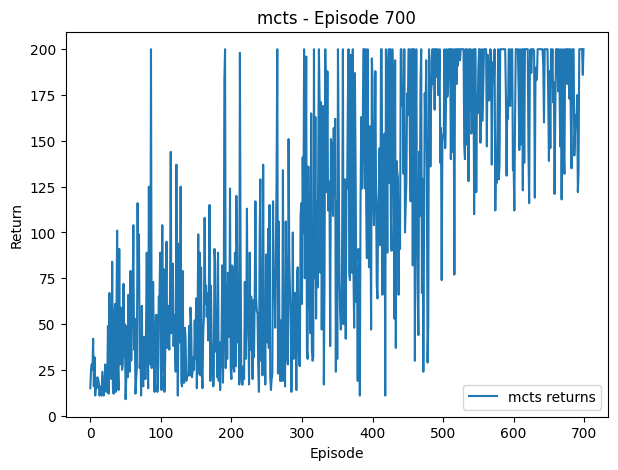

In [ ]:
def train_with_search_policy(search_type='mcts'):
    """
    Trains a MuZero_Agent with the given `search_type` using
    your exact train-loop code. We only add reward logging/plotting.
    """
    # Your same hyper-params:
    history_length = 3
    num_hidden = 50
    num_simulations = 25
    replay_capacity = 300
    batch_size = 32
    k = 5
    n = 10
    lr = 1e-3
    value_coef = 1
    reward_coef = 1
    raw_env = gym.make('CartPole-v0')
    num_obs_space = raw_env.observation_space.shape[0]
    num_actions = raw_env.action_space.n
    num_in = history_length * num_obs_space
    env = GymWrapper(raw_env, history_length)
    representation_model = RepresentationNet(num_in, num_hidden).to(device)
    dynamics_model = DynamicsNet(num_hidden, num_actions).to(device)
    prediction_model = PredictionNet(num_hidden, num_actions).to(device)
    agent = Agent(num_simulations, num_actions, representation_model, dynamics_model, prediction_model, search_type)
    runner = LoggingEnvRunner(env)
    replay_buffer = BufferReplay(replay_capacity, num_actions)
    mse_loss = nn.MSELoss()
    cross_entropy_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(agent.parameters(), lr=lr)
    for episode in range(1000):
        trajectory = runner.run(agent)
        replay_buffer.add_trajectories([trajectory])
        if len(replay_buffer) < 15:
            continue
        if episode < 250:
           agent.temperature = 1
        elif episode < 300:
            agent.temperature = 0.75
        elif episode < 400:
            agent.temperature = 0.65
        elif episode < 500:
            agent.temperature = 0.55
        elif episode < 600:
            agent.temperature = 0.3
        else:
            agent.temperature = 0.25
        for i in range(16):
            
            optimizer.zero_grad()
            data = replay_buffer.sample_batch(batch_size, k, n)
            representation_in = torch.stack(
                [torch.flatten(data[i]["obs"]) for i in range(batch_size)]
            ).to(device).to(dtype)
            actions = np.stack([np.array(data[i]["actions"], dtype=np.int64)
                                for i in range(batch_size)])
            rewards_target = torch.stack([torch.tensor(data[i]["rewards"])
                                          for i in range(batch_size)]).to(device).to(dtype)
            policy_target = torch.stack([torch.stack(data[i]["pi"])
                                         for i in range(batch_size)]).to(device).to(dtype)
            value_target = torch.stack([torch.tensor(data[i]["return"])
                                        for i in range(batch_size)]).to(device).to(dtype)
            loss = torch.tensor(0).to(device).to(dtype)
            # Initial step
            state, p, v = agent.initial_step(representation_in)
            policy_loss = cross_entropy_loss(p, policy_target[:, 0])
            
            value_loss = cross_entropy_loss(v.flatten(), value_target[:, 0].detach())
            loss += (policy_loss + value_coef * value_loss) / 2

            # k unroll steps
            for step in range(1, k + 1):
                step_action = actions[:, step - 1]
                state, p, v, rewards = agent.rollout_step(state, step_action)
                pol_loss = cross_entropy_loss(p, policy_target[:, step].detach())
                val_loss = cross_entropy_loss(v, value_target[:, step].detach())
                rew_loss = cross_entropy_loss(rewards, rewards_target[:, step - 1].detach())

                loss += (pol_loss + value_coef * val_loss + reward_coef * rew_loss) / k

            loss.backward()
            optimizer.step()
                    
        if (episode + 1) % 50 == 0:
            clear_output(True)
            plt.figure(figsize=(7,5))
            plt.plot(runner.episode_returns, label=f'{search_type} returns')
            plt.title(f'{search_type} - Episode {episode+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            plt.legend()
            plt.show()

    # Finally, return the entire list of returns so we can compare across runs
    return runner.episode_returns
all_results = {}
search_types = ['mcts','naive']

for s_type in search_types:
    returns = train_with_search_policy(s_type)
    all_results[s_type] = returns

plt.figure(figsize=(9,6))
for s_type in search_types:
    plt.plot(all_results[s_type], label=s_type)
plt.title("Comparison of MuZero Agents with Different Search Policies")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()


# Comparison of the Search Policies and results

Run training for each search policy and then compare final results. Each call uses the same code above but different `search_type`.

In [12]:
#### It was done the last part which you can see the mcts and naive outputs